In [2]:
from arguments import ModelParams, ArgumentParser, PipelineParams
from depth_images import calibrate_depth
from gaussian_renderer import GaussianModel
from scene import Scene
import matplotlib.pyplot as plt

parser = ArgumentParser()
pipe = PipelineParams(parser)
dataset = ModelParams(parser)
dataset.model_path = "output/chair_diffuse_lower_depth/"
#dataset.source_path = "../data/icl-nuim/livingroom1/"
dataset.source_path = "../data/chair/"
dataset.images = "images"
dataset.resolution = -1
dataset.white_background = False
dataset.initialisation = "depth"
dataset.eval=True
dataset.num_train_images = 20
gaussians = GaussianModel(dataset.sh_degree)
scene = Scene(dataset, gaussians,shuffle=False,load_iteration=8000)

Loading trained model at iteration 8000
Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Loading Training Cameras
Loading Test Cameras


In [6]:
gaussians.get_xyz.dtype

torch.float32

In [2]:
import torch
from utils.graphics_utils import geom_transform_points
from utils.graphics_utils import fov2focal
def get_normal(scale, q):
    local_normal = (scale==torch.amin(scale,dim=1).reshape((-1,1))).float()
    
    r = q[:,0]
    x = q[:,1]
    y = q[:,2]
    z = q[:,3]

    R = torch.stack([
        1 - 2 * (y * y + z * z), 2 * (x * y - r * z), 2 * (x * z + r * y),
        2 * (x * y + r * z), 1 - 2 * (x * x + z * z), 2 * (y * z - r * x),
        2 * (x * z - r * y), 2 * (y * z + r * x), 1 - 2 * (x * x + y * y)
    ],dim=1).reshape((-1,3,3))

    normals = (torch.bmm(local_normal.reshape((-1,1,3)), R)).reshape((-1,3))
    return normals/normals.norm(dim=1).unsqueeze(1)

def get_3d_point(pc,view_camera, pixel_coords):
    normals = get_normal(pc.get_scaling,pc.get_rotation)
    gaussian_pos_world = pc.get_xyz
    gaussian_pos_view = geom_transform_points(gaussian_pos_world, view_camera.world_view_transform)
    normal_view = (torch.cat([normals,torch.zeros_like(normals[:,:1])],dim=1) @ view_camera.world_view_transform)[:,:3]
    
    fx = fov2focal(view_camera.FoVx,view_camera.image_width)
    fy = fov2focal(view_camera.FoVy,view_camera.image_height)
    cx = view_camera.image_width/2
    cy = view_camera.image_height/2
    ray_view = torch.zeros((len(pixel_coords),3),device=pixel_coords.device).float()
    ray_view[:,0] = (pixel_coords[:,0] - cx)/fx
    ray_view[:,1]  = (pixel_coords[:,1] - cy)/fy
    ray_view[:,2]  = 1
    
    ray_view = ray_view/ray_view.norm(dim=1).reshape((-1,1))
    
    distance_to_intersection = torch.sum(gaussian_pos_view*normal_view,dim=1)/(torch.sum(ray_view*normal_view,dim=1)+1e-9)
    
    intersection_point_view = ray_view * distance_to_intersection.reshape((-1,1))
    
    intersection_point_world = geom_transform_points(intersection_point_view, torch.linalg.inv(view_camera.world_view_transform))
    
    return intersection_point_world

    

def get_uv_function(pc, view_camera, texture_camera):
    normals = get_normal(pc.get_scaling,pc.get_rotation)
    
    

In [3]:
# x = torch.tensor([1.0,2,7,1]).cuda()

# print(x @ torch.linalg.inv(view_camera.world_view_transform))
# print((x[:3]-view_camera.world_view_transform[3,:3]) @ view_camera.world_view_transform[:3,:3].T)

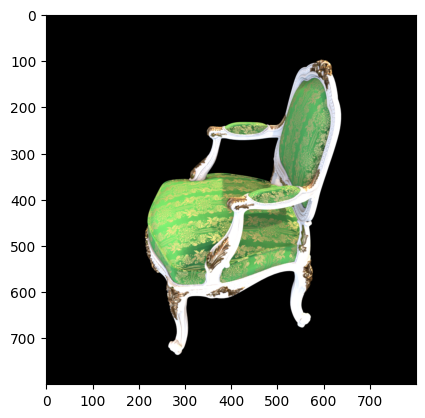

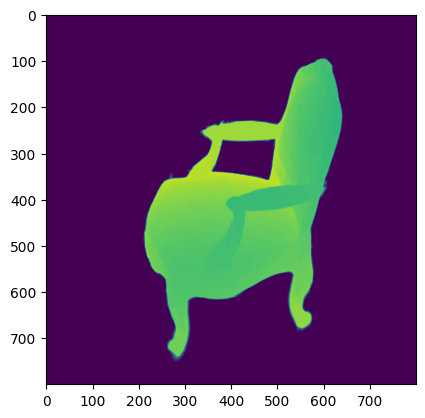

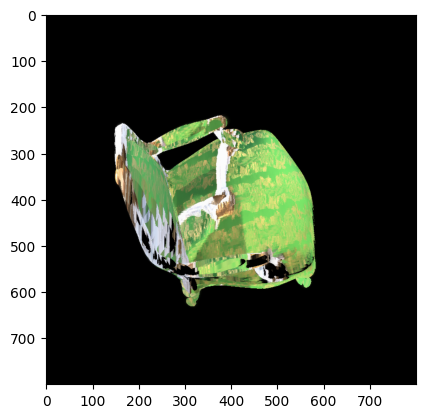

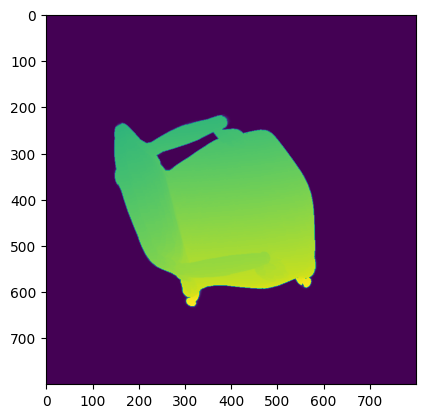

In [8]:
from gaussian_renderer import render
import torch
import os

from textured_render import prerender_depth

scene.gaussians.load_ply(os.path.join(scene.model_path,
                                                "point_cloud",
                                                "iteration_" + str(scene.loaded_iter),
                                                "point_cloud.ply"))
# view_camera = scene.getTrainCameras()[7]
# texture_cameras = scene.getTrainCameras()
# gaussians._xyz = gaussians._xyz[89:90]
# gaussians._features_dc = gaussians._features_dc[89:90]
# gaussians._features_rest = gaussians._features_rest[89:90]
# gaussians._scaling = gaussians._scaling[89:90]*torch.tensor([0.5,0.5,1]).cuda()
# gaussians._rotation = gaussians._rotation[89:90]
# gaussians._opacity = gaussians._opacity[89:90]*0+1

# render_pkg = render(view_camera,gaussians,pipe,torch.tensor([0,0,0], dtype=torch.float32, device="cuda"),texture_camera=texture_cameras[2])

# h = 800
# w = 800
# device = "cuda"

# pixel_coords = torch.zeros((h,w,2),device = device).float()
# pixel_coords[:,:,1], pixel_coords[:,:,0]  = torch.meshgrid(torch.arange(0,h,device=device),torch.arange(0,w,device=device),indexing="ij")

# colours = torch.clamp(get_3d_point(gaussians, view_camera,pixel_coords.reshape((-1,2))).reshape((h,w,3))*2+0.5+1.3,0,1)
# plt.imshow((colours*(0+1*render_pkg["render_opacity"].permute((1,2,0)))).cpu().detach(),vmin=0,vmax=1)
# plt.show()
# # plt.imshow((render_pkg["render_opacity"].permute((1,2,0))).cpu().detach(),vmin=0,vmax=1)
# # plt.show()
view_camera = scene.getTrainCameras()[0]
texture_cameras = scene.getTrainCameras()
bg = torch.tensor([0,0,0], dtype=torch.float32, device="cuda")
tex_cam_id = 2
prerender_depth(texture_cameras[tex_cam_id:tex_cam_id+1],gaussians,pipe,bg)
render_pkg = render(view_camera,gaussians,pipe,bg,texture_camera=texture_cameras[tex_cam_id])

plt.imshow(render_pkg["texture"][:3].cpu().detach().permute((1,2,0)))
plt.show()
plt.imshow(render_pkg["texture"][3].cpu().detach(),vmin=0,vmax=5)
plt.show()
plt.imshow(render_pkg["render"].cpu().detach().permute((1,2,0)))
plt.show()
plt.imshow(render_pkg["render_mask"].cpu().detach().permute((1,2,0)),vmin=0,vmax=5)

In [5]:
render_pkg["render_mask"]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [6]:
import open3d as o3d
import numpy as np
from utils.graphics_utils import fov2focal, geom_transform_points

ModuleNotFoundError: No module named 'open3d'

In [ ]:
from depth_images import camera_to_pcd

def camera_to_pcd2(camera):
    fx = fov2focal(camera.FoVx,camera.image_width)
    fy = fov2focal(camera.FoVy,camera.image_height)
    intrinics = o3d.camera.PinholeCameraIntrinsic(
        camera.image_width,
        camera.image_height,
        fx,
        fy,
        camera.image_width/2,
        camera.image_height/2,
    )
    print(fx,fy)

    depth_image = 1*camera.depth.numpy()[0].astype(np.float32)
    color_image = (camera.original_image.cpu().numpy().transpose((1,2,0))*255).astype(np.uint8)

    depth_image_o3d = o3d.geometry.Image(np.ascontiguousarray(depth_image))
    color_image_o3d = o3d.geometry.Image(np.ascontiguousarray(color_image))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_image_o3d,depth_image_o3d,depth_scale=1,depth_trunc=10000,convert_rgb_to_intensity=False)
    
    mat = camera.world_view_transform.cpu().numpy().T
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,intrinics,mat)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=2, max_nn=30))
    return pcd


all_pcds = []
for i,camera in enumerate(scene.getTrainCameras()):
    points,colors = camera_to_pcd(camera)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.ascontiguousarray(points.cpu()))
    pcd.colors = o3d.utility.Vector3dVector(np.ascontiguousarray(colors.cpu()))
    all_pcds.append(pcd)

In [ ]:
np.asarray(all_pcds[0].points)

array([[ 5.18871641,  3.30283928, -1.33148277],
       [ 5.18480253,  3.28903103, -1.33148277],
       [ 5.1808877 ,  3.27522278, -1.33148277],
       ...,
       [-3.49749804, -2.94404912, -1.33303344],
       [-3.50075579, -2.9555409 , -1.33303344],
       [-3.50401354, -2.96703219, -1.33303344]])

In [ ]:
0 or 65

65

In [ ]:
def pairwise_registration(source, target, radius):
    print("Apply point-to-plane ICP")
    icp_fine = o3d.registration.registration_colored_icp(
        source, target, radius,
        np.eye(4),
        o3d.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                          relative_rmse=1e-6,
                                                          max_iteration=50))
    
    transformation_icp = icp_fine.transformation
    information_icp = o3d.registration.get_information_matrix_from_point_clouds(
        source, target, radius,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, radius):
    pose_graph = o3d.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id],radius)
            print("Build o3d.registration.PoseGraph")
            if source_id == 0:  # odometry case
                #odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.registration.PoseGraphNode(np.linalg.inv(transformation_icp)))
                pose_graph.edges.append(
                    o3d.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

def register_pointclouds(all_pcds):
    print("Full registration ...")
    radius = 0.3
    #with o3d.utility.VerbosityContextManager(
    #        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(all_pcds,
                                    radius)

    # print("Optimizing PoseGraph ...")
    # option = o3d.registration.GlobalOptimizationOption(
    #     max_correspondence_distance=radius,
    #     edge_prune_threshold=0.25,
    #     reference_node=0)
    # # with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    # o3d.registration.global_optimization(
    #     pose_graph, o3d.registration.GlobalOptimizationLevenbergMarquardt(),
    #     o3d.registration.GlobalOptimizationConvergenceCriteria(), option)

    for point_id in range(len(all_pcds)):
        print(pose_graph.nodes[point_id].pose)
        all_pcds[point_id].transform(pose_graph.nodes[point_id].pose)

In [ ]:
def manual_reg(source, target):
  print("Apply point-to-plane ICP")

  threshold = 0.1
  trans_init = np.eye(4)
  
  # result_icp = o3d.registration.registration_icp(
  #     source, target, threshold, trans_init,
  #     o3d.registration.TransformationEstimationPointToPlane())


  result_icp = o3d.registration.registration_colored_icp(
          source, target, threshold, trans_init,
          o3d.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                          relative_rmse=1e-6,
                                                          max_iteration=50))
  print(result_icp)
  print("Transformation is:")
  print(result_icp.transformation)

  trans = np.linalg.inv(result_icp.transformation)
  target.transform(trans)
  return trans

In [ ]:
# register_pointclouds(all_pcds)
# save_pcds = all_pcds

import copy

save_pcds = [copy.deepcopy(all_pcds[i]) for i in range(len(all_pcds))]
transformations = [np.eye(4)]
ref_pcd = save_pcds[0]

# for i in range(1,len(all_pcds)):
#     transformations.append(manual_reg(ref_pcd,save_pcds[i]))
#     ref_pcd = ref_pcd+save_pcds[i]

In [ ]:
all_points = []
all_colors = []
for i,pcd in enumerate(save_pcds):
    points = np.array(pcd.points)
    colors = np.array(pcd.colors)
    
    # colors = np.zeros_like(points)
    # colors[:,i%3] = 1.0
    # if i>=3:
    #     colors[:,(i+1)%3] = 1.0
    
    all_points.append(points)
    all_colors.append(colors)
    
# all_points.append(np.stack([camera.camera_center.cpu().numpy() for camera in scene.getTrainCameras()]))
# all_colors.append(np.array([[1.0,0,0]]*len(scene.getTrainCameras())))
    

from depth_images import camera_frustrum_points

cam_frust_points = camera_frustrum_points(scene.getTrainCameras()[0])

all_points.append(cam_frust_points.cpu().numpy())
all_colors.append(np.array([[1.0,0,0]]*len(cam_frust_points)))

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.concatenate(all_points))
pcd.colors = o3d.utility.Vector3dVector(np.concatenate(all_colors))
o3d.io.write_point_cloud("test.ply", pcd)
#!cp test.ply /mnt/c/Users/fredr/repos/test.ply

True